# Simulation de l'évolution de la stabilité des clusters

Ce notebook a pour objectif de simuler l'évolution de la **stabilité des clusters** créés à partir des données **RFM**, des **scores de satisfaction client** et des **méthodes de paiement**, sur différentes périodes.

L'algorithme de clustering utilisé est **K-Means**, et la stabilité des clusters est mesurée grâce à l'indicateur **Adjusted Rand Index (ARI)**. Cette simulation permet de suivre l'évolution des clusters toutes les deux semaines sur une période donnée, afin d'évaluer si la segmentation reste cohérente dans le temps.

Les résultats obtenus permettront de formuler des recommandations sur la **fréquence optimale** à laquelle il serait nécessaire de mettre à jour la segmentation pour maintenir une pertinence maximale.

In [1]:
import warnings
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
# Charger les données
df = pd.read_csv('prepared_customer_data.csv')

# Afficher les premières lignes du dataframe pour vérifier le chargement
df.head()

,customer_unique_id,recency,frequency,total_spent,avg_review_score,product_variety,order_purchase_timestamp,payment_methods_boleto,payment_methods_credit_card,payment_methods_debit_card,payment_methods_not_defined,payment_methods_voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,160.273507,1,141.90,5.0,1,2018-05-10 10:56:27,False,True,False,False,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.263090,1,27.19,4.0,1,2018-05-07 11:11:27,False,True,False,False,False
2,0000f46a3911fa3c0805444483337064,585.850868,1,86.22,3.0,1,2017-03-10 21:05:03,False,True,False,False,False
3,0000f6ccb0745a6a4b88665a16c9f078,369.875428,1,43.62,4.0,1,2017-10-12 20:29:41,False,True,False,False,False
4,0004aac84e0df4da2b147fca70cf8255,336.905972,1,196.89,5.0,1,2017-11-14 19:45:42,False,True,False,False,False


## Simulation de l'évolution des clusters sur des périodes de 2 semaines

Dans cette section, nous simulons l'évolution de la stabilité des clusters au fil du temps en utilisant l'**ARI** (Adjusted Rand Index) comme mesure de divergence entre les clusters. L'objectif est d'analyser quand et comment les clusters évoluent, afin de déterminer le moment optimal pour réentraîner le modèle de clustering.

1. **Initialisation des paramètres :** Nous avons choisi de travailler avec **4 clusters**, ce nombre ayant été déterminé comme optimal à partir des résultats de la **méthode du coude** et du **Silhouette Score** obtenus dans le **notebook d'essais**.

2. **Mise à jour périodique des données :** Nous simulons l'évolution des clusters sur des périodes de deux semaines, en filtrant les nouvelles données au fur et à mesure, et en réentraînant le modèle à chaque intervalle. À chaque itération, les nouvelles données sont normalisées et intégrées dans le modèle, ce qui permet de recalculer l'ARI pour mesurer la divergence par rapport aux clusters de départ.

3. **Analyse de la stabilité :** L'ARI est calculé à chaque période pour comparer les clusters actuels avec ceux du départ. L'évolution de cet indice est tracée afin de visualiser comment la stabilité des clusters varie dans le temps. Ce suivi nous permet de formuler des recommandations concernant la **fréquence optimale de réentraînement** du modèle, afin de maintenir une segmentation pertinente.

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)

# Assurer que la colonne 'order_purchase_timestamp'
#  est bien en format datetime
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp']
)

# Filtrer les données jusqu'au 01/01/2018
initial_date = '2018-01-01 00:00:00'
df_start = df.loc[df['order_purchase_timestamp'] < initial_date, :]

# Normalisation des données initiales (avant le 01/01/2018)
features_to_scale = [
    'recency', 'frequency', 'total_spent'
]

scaler = MinMaxScaler()

df_startScaled = scaler.fit_transform(df_start[features_to_scale])

# Paramètres de la simulation
ncluster = 4  # Nombre de clusters
ari = []  # Liste pour stocker les scores ARI
simulation_start_date = '2018-01-01 00:00:00'  # Date de début

# Clustering initial avec les données normalisées
C0 = KMeans(n_clusters=ncluster, random_state=5).fit(df_startScaled)

# Créer un DataFrame pour la maintenance
# avec les données initiales normalisées
df_maintFinal = pd.DataFrame(df_startScaled, columns=features_to_scale)

In [4]:
# Filtrer les données futures (après 01/01/2018)
df_future = df.loc[df['order_purchase_timestamp'] >= simulation_start_date, :]

# Simulation de l'évolution des clusters sur des périodes de 2 semaines
"""
Cette boucle simule l'évolution des clusters dans le temps, en recalculant 
l'ARI toutes les deux semaines. Chaque itération met à jour les données, 
les normalise, réentraîne le modèle, et compare la stabilité des clusters 
avec l'ARI.
"""
while pd.to_datetime(simulation_start_date) < df[
    'order_purchase_timestamp'
].max():

    # Mettre à jour la date de début (+2 semaines)
    simulation_start_date = (
        pd.to_datetime(simulation_start_date) + pd.DateOffset(weeks=2)
    ).strftime('%Y-%m-%d %H:%M:%S')

    # Mettre à jour les données de maintenance (jusqu'à la nouvelle date)
    df_maint = df_future.loc[
        df_future['order_purchase_timestamp'] < simulation_start_date, :
    ]

    # Mettre à jour df_future avec les données après la nouvelle date
    df_future = df_future.loc[
        df_future['order_purchase_timestamp'] >= simulation_start_date, :
    ]

    # Normaliser les nouvelles données sans réajuster le scaler
    df_maintScaled = scaler.transform(df_maint[features_to_scale])

    # Ajouter les nouvelles données à notre DataFrame de maintenance
    df_maintFinal = pd.concat(
        [df_maintFinal, pd.DataFrame(
            df_maintScaled, columns=features_to_scale
        )]
    )

    # Recalculer le clustering sur toutes les données jusqu'à la date actuelle
    df_start = pd.concat([df_start, df_maint], axis=0)
    scaler_new = MinMaxScaler()
    df_maintNew_scaled = scaler_new.fit_transform(df_start[features_to_scale])

    # Effectuer un nouveau clustering
    C = KMeans(n_clusters=ncluster, random_state=5).fit(df_maintNew_scaled)

    # Calculer l'Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(
        C0.predict(df_maintFinal),  # Convertir en tableau NumPy
        C.predict(df_maintNew_scaled)
    )
    ari.append(ari_score)

    # Afficher l'ARI pour la période
    print(f"ARI pour la période {simulation_start_date}: {ari_score:.4f}")

ARI pour la période 2018-01-15 00:00:00: 0.8156
ARI pour la période 2018-01-29 00:00:00: 0.7449
ARI pour la période 2018-02-12 00:00:00: 0.6687
ARI pour la période 2018-02-26 00:00:00: 0.6105
ARI pour la période 2018-03-12 00:00:00: 0.4577
ARI pour la période 2018-03-26 00:00:00: 0.4604
ARI pour la période 2018-04-09 00:00:00: 0.4716
ARI pour la période 2018-04-23 00:00:00: 0.4865
ARI pour la période 2018-05-07 00:00:00: 0.4938
ARI pour la période 2018-05-21 00:00:00: 0.4892
ARI pour la période 2018-06-04 00:00:00: 0.4530
ARI pour la période 2018-06-18 00:00:00: 0.4452
ARI pour la période 2018-07-02 00:00:00: 0.4205
ARI pour la période 2018-07-16 00:00:00: 0.4152
ARI pour la période 2018-07-30 00:00:00: 0.2699
ARI pour la période 2018-08-13 00:00:00: 0.3794
ARI pour la période 2018-08-27 00:00:00: 0.2596
ARI pour la période 2018-09-10 00:00:00: 0.2569
ARI pour la période 2018-09-24 00:00:00: 0.2569
ARI pour la période 2018-10-08 00:00:00: 0.2571
ARI pour la période 2018-10-22 00:00:00:

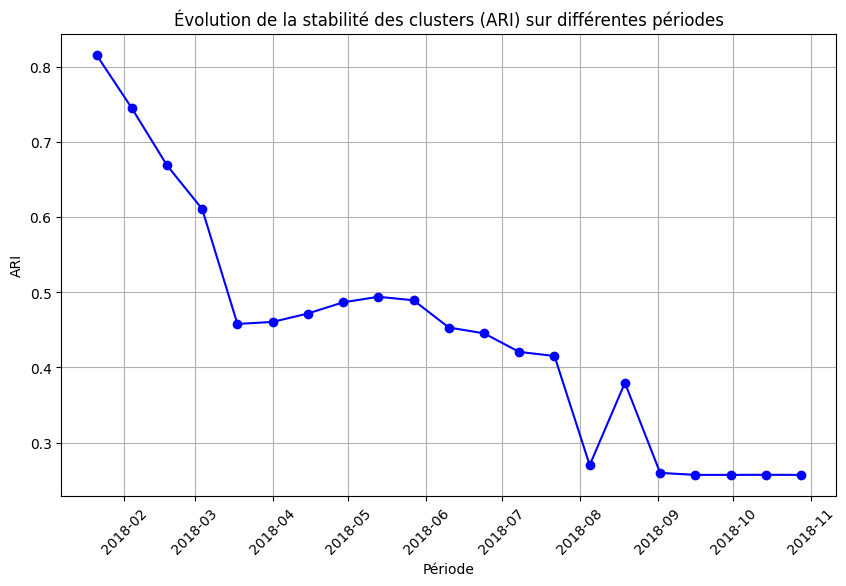

In [5]:
# Créer une liste des dates pour les périodes
dates = pd.date_range(start='2018-01-15', periods=len(ari), freq='2W')

# Tracer l'évolution du ARI
plt.figure(figsize=(10, 6))
plt.plot(dates, ari, marker='o', color='b')
plt.title(
    'Évolution de la stabilité des clusters (ARI) sur différentes périodes'
)
plt.xlabel('Période')
plt.ylabel('ARI')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Observations sur la Stabilité des Clusters avec MinMaxScaler

Après avoir observé l'évolution de l'Adjusted Rand Index (ARI) avec le `MinMaxScaler`, il apparaît que la stabilité des clusters se dégrade de manière assez marquée au fil des périodes. Cette décroissance rapide de l'ARI indique que les clusters se réajustent significativement sur plusieurs intervalles de temps, ce qui pourrait refléter une variabilité plus élevée dans les données. 

Pour tester une approche alternative et vérifier si cette instabilité est liée à la méthode de normalisation, j’ai décidé d’essayer avec le `StandardScaler`. Ce changement de scaler permettra de voir si une autre normalisation améliore la cohérence des clusters dans le temps.

In [6]:
# Assurer que la colonne 'order_purchase_timestamp'
#  est bien en format datetime
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp']
)

# Filtrer les données jusqu'au 01/01/2018
initial_date = '2018-01-01 00:00:00'
df_start = df.loc[df['order_purchase_timestamp'] < initial_date, :]

# Normalisation des données initiales (avant le 01/01/2018)
features_to_scale = [
    'recency', 'frequency', 'total_spent'
]

scaler = StandardScaler()

df_startScaled = scaler.fit_transform(df_start[features_to_scale])

# Paramètres de la simulation
ncluster = 4  # Nombre de clusters
ari = []  # Liste pour stocker les scores ARI
simulation_start_date = '2018-01-01 00:00:00'  # Date de début

# Clustering initial avec les données normalisées
C0 = KMeans(n_clusters=ncluster, random_state=5).fit(df_startScaled)

# Créer un DataFrame pour la maintenance
# avec les données initiales normalisées
df_maintFinal = pd.DataFrame(df_startScaled, columns=features_to_scale)

In [7]:
# Filtrer les données futures (après 01/01/2018)
df_future = df.loc[df['order_purchase_timestamp'] >= simulation_start_date, :]

# Simulation de l'évolution des clusters sur des périodes de 2 semaines
"""
Cette boucle simule l'évolution des clusters dans le temps, en recalculant 
l'ARI toutes les deux semaines. Chaque itération met à jour les données, 
les normalise, réentraîne le modèle, et compare la stabilité des clusters 
avec l'ARI.
"""
while pd.to_datetime(simulation_start_date) < df[
    'order_purchase_timestamp'
].max():

    # Mettre à jour la date de début (+2 semaines)
    simulation_start_date = (
        pd.to_datetime(simulation_start_date) + pd.DateOffset(weeks=2)
    ).strftime('%Y-%m-%d %H:%M:%S')

    # Mettre à jour les données de maintenance (jusqu'à la nouvelle date)
    df_maint = df_future.loc[
        df_future['order_purchase_timestamp'] < simulation_start_date, :
    ]

    # Mettre à jour df_future avec les données après la nouvelle date
    df_future = df_future.loc[
        df_future['order_purchase_timestamp'] >= simulation_start_date, :
    ]

    # Normaliser les nouvelles données sans réajuster le scaler
    df_maintScaled = scaler.transform(df_maint[features_to_scale])

    # Ajouter les nouvelles données à notre DataFrame de maintenance
    df_maintFinal = pd.concat(
        [df_maintFinal, pd.DataFrame(
            df_maintScaled, columns=features_to_scale
        )]
    )

    # Recalculer le clustering sur toutes les données jusqu'à la date actuelle
    df_start = pd.concat([df_start, df_maint], axis=0)
    scaler_new = StandardScaler()
    df_maintNew_scaled = scaler_new.fit_transform(df_start[features_to_scale])

    # Effectuer un nouveau clustering
    C = KMeans(n_clusters=ncluster, random_state=5).fit(df_maintNew_scaled)

    # Calculer l'Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(
        C0.predict(df_maintFinal),  # Convertir en tableau NumPy
        C.predict(df_maintNew_scaled)
    )
    ari.append(ari_score)

    # Afficher l'ARI pour la période
    print(f"ARI pour la période {simulation_start_date}: {ari_score:.4f}")

ARI pour la période 2018-01-15 00:00:00: 0.9079
ARI pour la période 2018-01-29 00:00:00: 0.8440
ARI pour la période 2018-02-12 00:00:00: 0.7766
ARI pour la période 2018-02-26 00:00:00: 0.7446
ARI pour la période 2018-03-12 00:00:00: 0.7046
ARI pour la période 2018-03-26 00:00:00: 0.6693
ARI pour la période 2018-04-09 00:00:00: 0.6361
ARI pour la période 2018-04-23 00:00:00: 0.6174
ARI pour la période 2018-05-07 00:00:00: 0.5981
ARI pour la période 2018-05-21 00:00:00: 0.5736
ARI pour la période 2018-06-04 00:00:00: 0.5695
ARI pour la période 2018-06-18 00:00:00: 0.4146
ARI pour la période 2018-07-02 00:00:00: 0.5338
ARI pour la période 2018-07-16 00:00:00: 0.5286
ARI pour la période 2018-07-30 00:00:00: 0.2822
ARI pour la période 2018-08-13 00:00:00: 0.3660
ARI pour la période 2018-08-27 00:00:00: 0.3446
ARI pour la période 2018-09-10 00:00:00: 0.3451
ARI pour la période 2018-09-24 00:00:00: 0.3448
ARI pour la période 2018-10-08 00:00:00: 0.3439
ARI pour la période 2018-10-22 00:00:00:

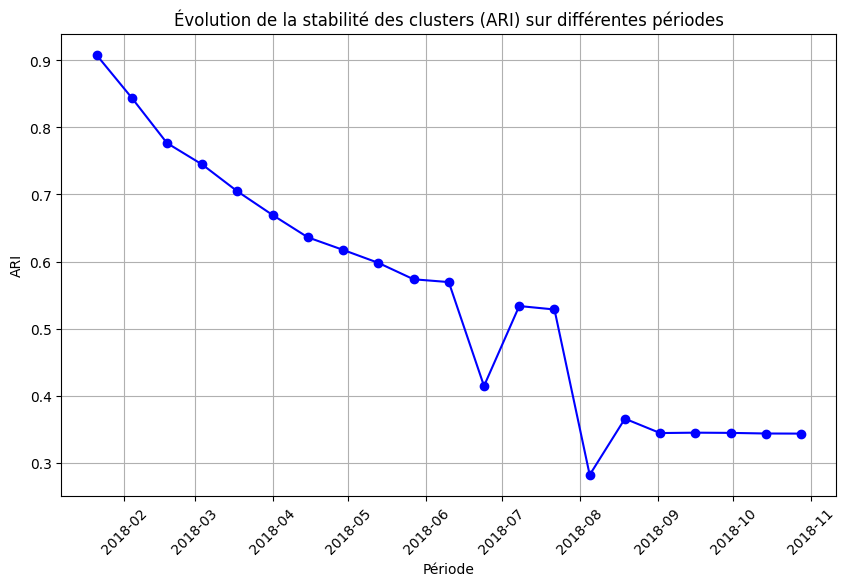

In [8]:
# Créer une liste des dates pour les périodes
dates = pd.date_range(start='2018-01-15', periods=len(ari), freq='2W')

# Tracer l'évolution du ARI
plt.figure(figsize=(10, 6))
plt.plot(dates, ari, marker='o', color='b')
plt.title(
    'Évolution de la stabilité des clusters (ARI) sur différentes périodes'
)
plt.xlabel('Période')
plt.ylabel('ARI')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Analyse des Résultats avec StandardScaler

Les résultats avec le `StandardScaler` montrent une amélioration notable dans la stabilité des clusters. Bien que l’ARI décroisse également, la diminution est plus progressive comparée à celle obtenue avec le `MinMaxScaler`. Cela suggère que les clusters sont plus stables avec le `StandardScaler`, ce qui pourrait indiquer une meilleure adaptation de cette méthode aux caractéristiques de mes données.

En conclusion, bien que les deux méthodes permettent de segmenter les clients, le `StandardScaler` semble offrir une meilleure stabilité des clusters au fil du temps. Ce choix pourrait ainsi être privilégié pour la segmentation, car il permet de maintenir une cohérence plus forte, facilitant ainsi la mise en œuvre de stratégies marketing durables et fiables.

In [9]:
# Liste mise à jour des features numériques à analyser
numeric_features = [
    'recency',
    'frequency',
    'total_spent'
]

# Périodes successives (exemple : bimensuel)
periods = pd.date_range(start='2018-01-01', end='2018-10-22', freq='2W')

# Initialisation des listes pour stocker les résultats
period_list = []
feature_list = []
ks_stat_list = []
p_value_list = []

# Comparer les distributions des features pour chaque période successivement
for i in range(len(periods) - 1):
    start_date = periods[i]
    end_date = periods[i + 1]

    # Filtrer les données pour chaque période
    data_period_1 = df[
        (df['order_purchase_timestamp'] >= start_date) &
        (df['order_purchase_timestamp'] < end_date)
    ]
    if i < len(periods) - 2:
        data_period_2 = df[
            (df['order_purchase_timestamp'] >= end_date) &
            (df['order_purchase_timestamp'] < periods[i + 2])
        ]
    else:
        # Dernière période comparée à la période juste avant
        data_period_2 = df[(df['order_purchase_timestamp'] >= end_date)]

    # Appliquer le test KS pour chaque feature
    for feature in numeric_features:
        ks_stat, p_value = ks_2samp(
            data_period_1[feature], data_period_2[feature]
        )

        # Stocker les résultats dans les listes
        period_list.append(
            f'{start_date.strftime("%Y-%m-%d")} - '
            f'{end_date.strftime("%Y-%m-%d")}'
        )
        feature_list.append(feature)
        ks_stat_list.append(ks_stat)
        p_value_list.append(p_value)

# Créer un DataFrame avec les résultats
ks_df = pd.DataFrame({
    'Période': period_list,
    'Feature': feature_list,
    'Statistique KS': ks_stat_list,
    'p-value': p_value_list
})

# Afficher le tableau des résultats
ks_df

,Période,Feature,Statistique KS,p-value
0,2018-01-07 - 2018-01-21,recency,1.000000,0.000000e+00
1,2018-01-07 - 2018-01-21,frequency,0.001011,1.000000e+00
2,2018-01-07 - 2018-01-21,total_spent,0.016939,7.322794e-01
3,2018-01-21 - 2018-02-04,recency,1.000000,0.000000e+00
4,2018-01-21 - 2018-02-04,frequency,0.006212,1.000000e+00
5,2018-01-21 - 2018-02-04,total_spent,0.018137,6.801527e-01
6,2018-02-04 - 2018-02-18,recency,1.000000,0.000000e+00
7,2018-02-04 - 2018-02-18,frequency,0.002662,1.000000e+00
8,2018-02-04 - 2018-02-18,total_spent,0.021476,4.298095e-01
9,2018-02-18 - 2018-03-04,recency,1.000000,0.000000e+00


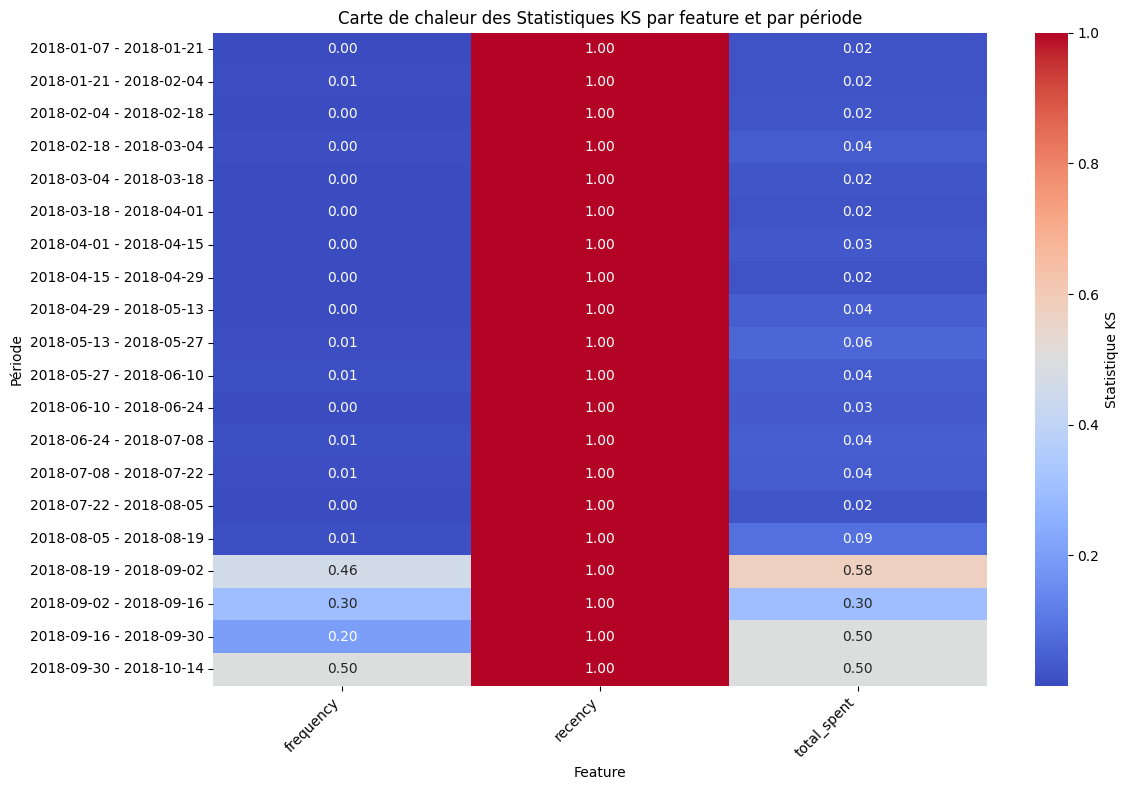

In [10]:
# Pivot le DataFrame pour avoir les périodes en lignes
# et les features en colonnes
ks_pivot = ks_df.pivot_table(
    index='Période', columns='Feature', values='Statistique KS'
)

# Créer une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    ks_pivot, annot=True, fmt=".2f", cmap='coolwarm',
    cbar_kws={'label': 'Statistique KS'}
)
plt.title('Carte de chaleur des Statistiques KS par feature et par période')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

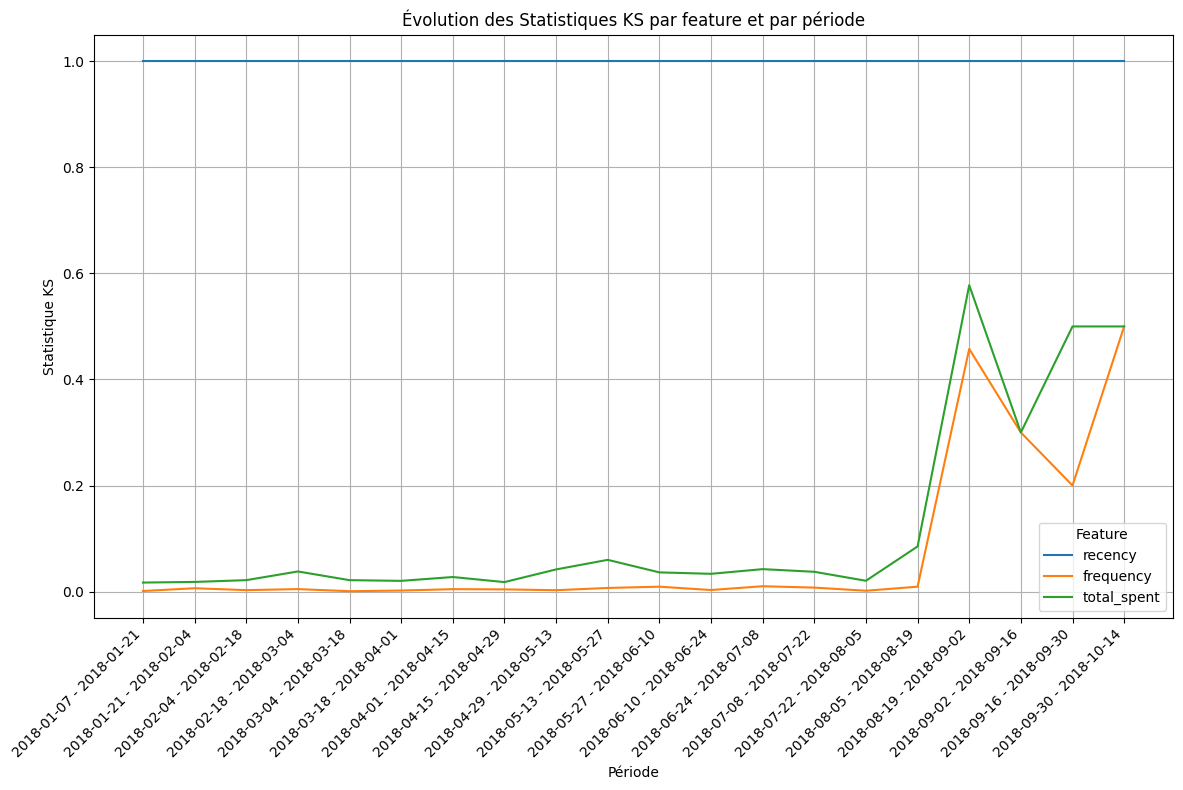

In [11]:
plt.figure(figsize=(12, 8))

# Boucler sur chaque feature et tracer la courbe des KS
for feature in ks_df['Feature'].unique():
    feature_data = ks_df[ks_df['Feature'] == feature]
    plt.plot(
        feature_data['Période'], feature_data['Statistique KS'], 
        label=feature
    )

plt.title('Évolution des Statistiques KS par feature et par période')
plt.xlabel('Période')
plt.ylabel('Statistique KS')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyse des Résultats du Test de Kolmogorov-Smirnov (KS)

Le test de Kolmogorov-Smirnov (KS) a été effectué pour évaluer la stabilité des distributions des différentes caractéristiques (recency, frequency, total_spent) à travers les périodes. Voici les principaux points observés :

### Recency
Pour chaque période, la statistique KS pour la variable `recency` reste constante à 1.0, avec une p-value de 0. Cela suggère des différences marquées et constantes dans les distributions de récence entre les périodes successives. Ce résultat indique une grande variabilité dans le temps depuis le dernier achat des clients, signalant potentiellement des comportements d'achat changeants qui pourraient nécessiter une réévaluation fréquente de la segmentation.

### Frequency
La variable `frequency` montre des statistiques KS très faibles, proches de zéro, avec des p-values souvent proches de 1.0, ce qui indique une forte stabilité dans cette caractéristique sur la plupart des périodes. Cependant, une exception notable apparaît entre le 19 août et le 2 septembre 2018, où la statistique KS atteint 0.4577 avec une p-value de 0.0483, indiquant une variation significative de la fréquence d'achat. Cela pourrait correspondre à une période de changement dans le comportement des clients, peut-être en réponse à des événements externes ou des offres promotionnelles.

### Total Spent
La variable `total_spent` montre quelques variations notables dans plusieurs périodes :
- Du 13 au 27 mai 2018, on observe une statistique KS de 0.0598 avec une p-value très faible (0.0002), indiquant une divergence significative dans les montants dépensés.
- Entre le 19 août et le 2 septembre 2018, la statistique KS atteint 0.5778 avec une p-value de 0.0048, signalant une importante fluctuation dans les dépenses des clients durant cette période. Cela pourrait indiquer des changements dans les comportements d'achat, possiblement influencés par des promotions ou d'autres facteurs externes.
- Des fluctuations sont également observées à d'autres moments, bien que moins marquées.

### Conclusion
Les résultats du test de Kolmogorov-Smirnov révèlent une stabilité globale dans les caractéristiques de `frequency`, mais des changements constants et importants pour `recency`. De plus, certaines périodes montrent des variations significatives dans `total_spent`, notamment en mai et août-septembre 2018. Ces fluctuations dans les comportements d'achat, en particulier dans les montants dépensés, suggèrent qu'il serait pertinent de surveiller ces caractéristiques de près et de re-segmenter les clients lors des périodes de forte variation, afin de maintenir une segmentation pertinente et adaptée aux évolutions des comportements clients.

## Conclusion Générale et Recommandations

Cette analyse a exploré la stabilité des clusters à travers deux approches de normalisation (`MinMaxScaler` et `StandardScaler`) et a permis d'évaluer l'évolution des clusters dans le temps en utilisant l'Adjusted Rand Index (ARI) et le test de Kolmogorov-Smirnov (KS).

### Observations Clés

1. **Choix de la Méthode de Normalisation** :
   - Les résultats ont montré que le `StandardScaler` offrait une meilleure stabilité des clusters, avec un ARI qui diminue de manière plus progressive comparé au `MinMaxScaler`. Cette stabilité accrue facilite le maintien d'une segmentation cohérente dans le temps, ce qui est essentiel pour des stratégies marketing durables.

2. **Stabilité des Clusters dans le Temps** :
   - Bien que le `StandardScaler` améliore la stabilité, l'ARI montre des baisses significatives après environ 6 semaines, suggérant que la segmentation deviendrait moins pertinente si les mises à jour sont espacées. Il est donc recommandé de réentraîner le modèle tous les 1 mois et demi afin de maintenir l'ARI au-dessus de 0.8 et de garantir une segmentation pertinente et réactive aux évolutions comportementales.

3. **Insights des Tests KS** :
   - Le test de Kolmogorov-Smirnov a révélé une forte variabilité dans la variable `recency`, indiquant des changements constants dans le comportement d'achat. La stabilité des variables `frequency` et `total_spent` est, en revanche, plus élevée, bien que certaines périodes montrent des fluctuations importantes, particulièrement en août et septembre 2018. Cela suggère que ces périodes pourraient bénéficier d'une attention particulière pour ajuster la segmentation.

### Recommandations

En résumé, pour maintenir une segmentation performante :
   - **Utiliser le `StandardScaler`** comme méthode de normalisation pour assurer la stabilité des clusters dans le temps.
   - **Mettre à jour la segmentation tous les 1 mois et demi** afin de maintenir la stabilité de l'ARI au-dessus de 0.8, garantissant ainsi une réactivité aux changements dans les comportements des clients.
   - **Surveiller de près les périodes avec de fortes variations**, identifiées par les tests KS, pour ajuster rapidement la segmentation si nécessaire.

Ces recommandations permettront de maintenir une segmentation précise et d'optimiser l'engagement client de manière dynamique et efficace.